In [1]:
import csv
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np

from tqdm.auto import tqdm
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

BATCH_SIZE = 10
IMAGE_SHAPE = (128, 128)
PROCESSED_DATASET_PATH_MNETV1_TEST = Path("../../../../dataset/processed/test/")


PRETRAINED_MODEL = "./logs/models/model_e10.pth"

print(device)

cuda:0


In [2]:
test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_MNETV1_TEST, transform=test_transform)
test_loader = DataLoader(test_set, shuffle=True)

In [3]:
model = torchvision.models.mobilenet_v2(num_classes=len(test_set.classes), pretrained=False)
model = model.to(device)
model.load_state_dict(torch.load(PRETRAINED_MODEL))
model.eval()

c:\Users\Deep Raval\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Deep Raval\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

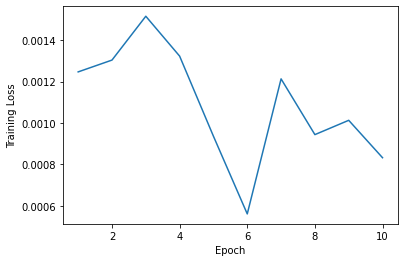

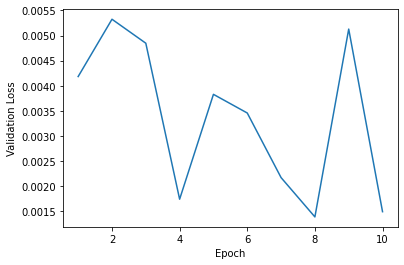

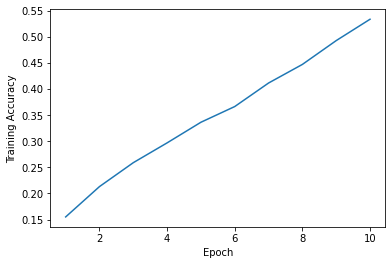

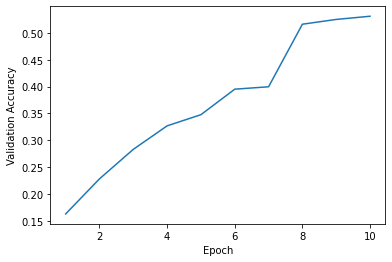

In [4]:
# Loss and acc graph
import pandas as pd

df = pd.read_csv("./logs/training_logs.csv")

plt.figure("Epoch vs Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.plot(df["epoch"], df["train_loss"])
plt.show()

plt.figure("Epoch vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.plot(df["epoch"], df["val_loss"])
plt.show()

plt.figure("Epoch vs Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.plot(df["epoch"], df["train_acc"])
plt.show()

plt.figure("Epoch vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.plot(df["epoch"], df["val_acc"])
plt.show()

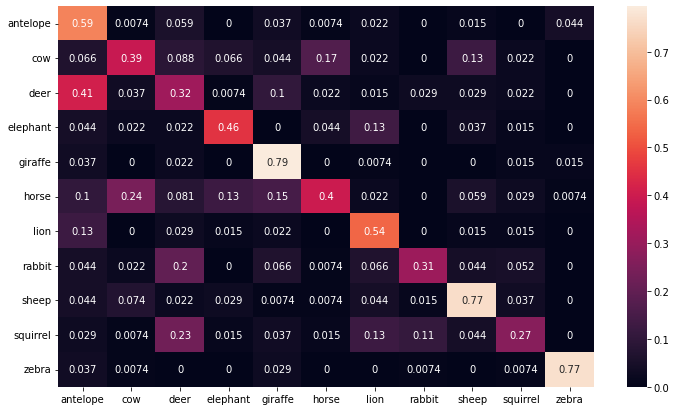

In [5]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []


# iterate over test data
for images, labels in test_loader:
        output = np.squeeze(model(images.cuda()).data.max(1, keepdim=True)[1].cpu().numpy())
        y_pred.extend([output]) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend([labels]) # Save Truth

# constant for classes
classes = test_set.classes

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('./confusion_mnetv1.png')